In [2]:
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import keras 
from keras.models import Sequential, Model,load_model
from keras.layers import Input, Dense, Conv1D, Dropout, Activation, GaussianNoise
from keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn import metrics, svm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from IPython.display import clear_output
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from keras.optimizers import SGD
import tensorflow
import json
import array
import random
import numpy
import pickle
from math import sqrt
import time
import pickle
import talos as ta
#matplotlib inline

Using TensorFlow backend.


XePhotEnergyL = 6000.     # Ev
XePhotEnergyH = 12500.

XeMultVoltagL = 600.      # V
XeMultVoltagH = 1600.

XePulseEnergL = 10        # uJ
XePulseEnergH = 500

In [10]:
#found online for axis formatting
import matplotlib.ticker as mticker

class MathTextSciFormatter(mticker.Formatter):
    def __init__(self, fmt="%1.2e"):
        self.fmt = fmt
    def __call__(self, x, pos=None):
        s = self.fmt % x
        decimal_point = '.'
        positive_sign = '+'
        tup = s.split('e')
        significand = tup[0].rstrip(decimal_point)
        sign = tup[1][0].replace(positive_sign, '')
        exponent = tup[1][1:].lstrip('0')
        if exponent:
            exponent = '10^{%s%s}' % (sign, exponent)
        if significand and exponent:
            s =  r'%s{\times}%s' % (significand, exponent)
        else:
            s =  r'%s%s' % (significand, exponent)
        return "${}$".format(s)
    
# define class for showing training plot - found online
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.yscale('log')
        plt.ylabel('error')
        plt.xlabel('epoch')
        plt.show();
        
plot_losses = PlotLosses()


class PlotAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.val_acc = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.acc, label="accuracy")
        plt.plot(self.x, self.val_acc, label="val_accuracy")
        plt.legend()
        plt.ylabel('error')
        plt.xlabel('epoch')
        plt.show();

plot_accuracy = PlotAccuracy()

def plotModelPerf2(m, modelDesc, X_RS, y_RSscaled, y_var_list, figDir):

    colNames = y_var_list.append(pd.Index([modelDesc]))
    errDf = pd.DataFrame(columns=colNames)                           
    Y_pred5 = m.predict(X_RS)
    Y_pred5_inv = transformer_y.inverse_transform(Y_pred5)
    
    y_RS = transformer_y.inverse_transform(y_RSscaled)
    
    #fig.subplots_adjust(wspace=1.,hspace=1.)
    err = []
    for i in range(0,y_RS.shape[1]):
        fig = plt.figure(figsize=(8,8))
        #ax = fig.add_subplot(6, 2, i+1)
        indx = np.argsort(y_RS[:,i])    # y_RS_inv
        plt.plot(Y_pred5_inv[indx,i],y_RS[indx,i], marker='o', linestyle='')
        plt.plot(y_RS[indx,i],y_RS[indx,i])
        
        plt.ylabel(y_var_list[i] + ' of Random Sample')
        plt.xlabel(y_var_list[i] + ' of Surrogate Model')
        plt.savefig(figDir + y_var_list[i] + '.png')
        
        merr = metrics.mean_absolute_error(Y_pred5_inv[indx,i],y_RS[indx,i])
        
        plt.title(modelDesc + ' MAE= ' + "{:.3e}".format(merr), fontsize=8)
        err.append(merr)
    err.append(modelDesc)
    errDf.loc[len(errDf)] = err
    return errDf

def makeDataSetInterpolated(directory, excelFn, doInterpolate=True, dropBadPulses=True, verbose=False,
                           CALCTthreshold=-50, CALCSthreshold=-50):
    first = True
    data = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith(".csv"):
            fntmp = re.sub(r'.*dp', '', filename)
            expNumber = re.sub(r'-nomeans.csv', '', fntmp)
            file_excel = pd.read_excel(excelFn)
            multVoltag = file_excel.iloc[int(expNumber)]['XeMultVoltag'] 
            try:
                dp  = pd.read_csv(directory+filename, sep=";") 
            except:
                print ("Can not read " + directory + filename)
                continue
                
            dp = dp[['SARFE10-PBIG050-EVR0:CALCT.value', 
                    'SARFE10-PBIG050-EVR0:CALCS.value',
                    'SARFE10-PSSS059:SPECTRUM_CENTER.value',
                    'SARFE10-PBPG050:PHOTON-ENERGY-PER-PULSE-AVG.value']]
            dp.columns = ['CALCT','CALCS','SPECTRUM_CENTER','PHOTON-ENERGY-PER-PULSE']

            if doInterpolate:
                dp['PHOTON-ENERGY-PER-PULSE'].interpolate(method='linear', 
                                                              inplace=True, 
                                                              limit_direction='forward', 
                                                              axis=0)
            
            dp = dp.dropna();

            # condition for bad pulse
            if dropBadPulses:
                validT = dp['CALCT'] < CALCTthreshold
                validS = dp['CALCS'] < CALCSthreshold
                dp = dp[validT & validS]
            
            dp['XeMultVoltag'] = multVoltag
            dp['rawDataFile']  = filename
            
            if first:
                data = dp
                first = False
            else:
                data = data.append(dp,ignore_index=True)

            if verbose:
                print("Datapoint", expNumber, "gave", len(dp), "values")
    data.reset_index(inplace=True)
    data.dropna()
    return data

In [11]:
def build_ff_mdl_small(in_dim = 2, out_dim = 1, l1 = 8, l2 = 6, l3 = 4, l4= 4, 
                       opt = 'adam', loss = 'mse', act = 'tanh', l2reg = 0.00, gn=0.001):
    layer_0 = Input(shape=(in_dim,))
    layer_1 = Dense(l1, activation=act, activity_regularizer=regularizers.l2(l2reg))(layer_0)
    layer_1 = GaussianNoise(gn)(layer_1)
    layer_2 = Dense(l2, activation=act, activity_regularizer=regularizers.l2(l2reg))(layer_1)
    layer_2=GaussianNoise(gn)(layer_2)
    layer_3 = Dense(l3, activation=act, activity_regularizer=regularizers.l2(l2reg))(layer_2)
    layer_4 = Dense(l4, activation=act, activity_regularizer=regularizers.l2(l2reg))(layer_3)
    layer_4=GaussianNoise(gn)(layer_4)
    layer_5 = Dense(out_dim, activation='linear')(layer_4)
    model = Model(inputs=layer_0, outputs=layer_5)
    model.compile(loss=loss, optimizer=opt, metrics=['mse'])
    return model


def build_ff_mdl_smallnn(in_dim = 2, out_dim = 1, l1 = 8, l2 = 6, l3 = 4, l4= 4, 
                         opt = 'adam', loss = 'mse', act = 'tanh', l2reg = 0.00):
    layer_0 = Input(shape=(in_dim,))
    layer_1 = Dense(l1, activation=act, activity_regularizer=regularizers.l2(l2reg))(layer_0)
    layer_2 = Dense(l2, activation=act, activity_regularizer=regularizers.l2(l2reg))(layer_1)
    layer_3 = Dense(l3, activation=act, activity_regularizer=regularizers.l2(l2reg))(layer_2)
    layer_4 = Dense(l4, activation=act, activity_regularizer=regularizers.l2(l2reg))(layer_3)
    layer_5 = Dense(out_dim, activation='linear')(layer_4)
    model = Model(inputs=layer_0, outputs=layer_5)
    model.compile(loss=loss, optimizer=opt, metrics=['mse'])
    return model




# Make dataset 

(Can not read /psi/home/adelmann/SwissFEL-Gas-1/cleaned/dp41-nomeans.csv is ok)

In [27]:
directory = "/psi/home/adelmann/data/ml-gasmon/cleaned/"
xlsxFn    = '/psi/home/adelmann/data/ml-gasmon/XeX77.xlsx'
data      = makeDataSetInterpolated(directory,xlsxFn,CALCTthreshold=-50,CALCSthreshold=-50,verbose=False)

Can not read /psi/home/adelmann/data/ml-gasmon/cleaned/dp41-nomeans.csv


In [28]:
data.tail()

index       CALCT        CALCS  SPECTRUM_CENTER  \
144414  144414 -315.269553 -1053.430080     12252.481081   
144415  144415 -566.740475 -1925.769260     12261.304511   
144416  144416 -918.766152 -3192.116020     12248.668694   
144417  144417 -459.352855 -1530.998159     12255.365829   
144418  144418 -867.274811 -2952.268258     12254.893320   

        PHOTON-ENERGY-PER-PULSE  XeMultVoltag       rawDataFile  
144414               174.270415   1519.587301  dp76-nomeans.csv  
144415               174.294678   1519.587301  dp76-nomeans.csv  
144416               174.318941   1519.587301  dp76-nomeans.csv  
144417               174.343204   1519.587301  dp76-nomeans.csv  
144418               174.367467   1519.587301  dp76-nomeans.csv

In [20]:
#nr files actually used
data['rawDataFile'].nunique()

49

In [ ]:
#data['SPECTRUM_CENTER'].hist(bins=100)

In [ ]:
#data['PHOTON-ENERGY-PER-PULSE'].hist(bins=100)

In [ ]:
#data['XeMultVoltag'].hist(bins=100)

# Training/Test Split

In [29]:
train, validate, test = np.split(data.sample(frac=1), [int(.6*len(data)), int(.8*len(data))])

x_train    = train[['SPECTRUM_CENTER','XeMultVoltag','CALCT','CALCS']]
y_train    = train[['PHOTON-ENERGY-PER-PULSE']]
x_validate = validate[['SPECTRUM_CENTER','XeMultVoltag','CALCT','CALCS']]
y_validate = validate[['PHOTON-ENERGY-PER-PULSE']]
x_test     = test[['SPECTRUM_CENTER','XeMultVoltag','CALCT','CALCS']]
y_test     = test[['PHOTON-ENERGY-PER-PULSE']]

# SVM to see what a linear model can do

In [ ]:
clf = svm.SVR()
clf.fit(x_train, y_train)
y_pred=clf.predict(x_test).ravel()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

# Train DNN

## Make a scaler and scale to -1 ... 1

In [30]:
transformer_x = 0
transformer_y = 0

In [31]:
transformer_x = MinMaxScaler(feature_range=(-1, 1)).fit(data[['SPECTRUM_CENTER','XeMultVoltag','CALCT','CALCS']].values)
transformer_y = MinMaxScaler(feature_range=(-1, 1)).fit(data[['PHOTON-ENERGY-PER-PULSE']].values)

In [32]:
x_train    = transformer_x.transform(x_train)
x_validate = transformer_x.transform(x_validate)
x_test     = transformer_x.transform(x_test)

y_train    = transformer_y.transform(y_train)
y_validate = transformer_y.transform(y_validate)
y_test     = transformer_y.transform(y_test)

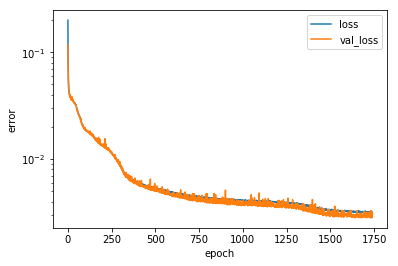

Epoch 01740: early stopping


In [33]:
model_0 = build_ff_mdl_small(in_dim  = x_train.shape[1], 
                             out_dim = y_train.shape[1])
#mc = keras.callbacks.ModelCheckpoint('best_model_1.h5', monitor='val_loss', mode='min', save_best_only=True)
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
hist_0 = model_0.fit(x=x_train, y=y_train, 
                     validation_data=(x_validate,y_validate),
                     batch_size=250, shuffle='true',epochs=2000, 
                     verbose='false', callbacks=[plot_losses,es])

Mean Absolute Error: 0.03234131628858797
Mean Squared Error: 0.0037518498182099853
Root Mean Squared Error: 0.06125234540986969


PHOTON-ENERGY-PER-PULSE  Model 0
0                  7.14618  Model 0

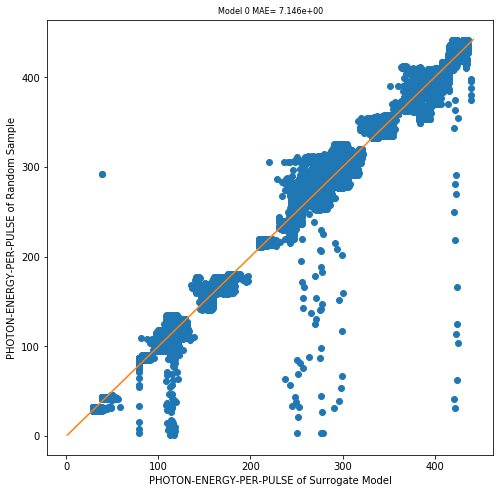

In [34]:
y_pred=model_0.predict(x_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
plotModelPerf2(model_0, 'Model 0', x_test, y_test, test[['PHOTON-ENERGY-PER-PULSE']].columns, '.')

# The code below is not yet tested

# Make a hyperparameter scan A

In [ ]:
from keras.activations import relu, elu

params = {
    'mult_neuron': [1, 2, 4],
    'activation': ['relu', 'elu', 'tanh'],
    'batch_size': [10, 25, 50, 100]
}

In [ ]:
def build_ff_mdl_smallA(params, in_dim = 2, out_dim = 1, 
                       l1 = 8, l2 = 6, l3 = 4, l4= 4, opt = 'adam', loss = 'mse', l2reg = 0.00, gn=0.001):
    layer_0 = Input(shape=(in_dim,))
    layer_1 = Dense(l1, activation=params['activation'], 
                    activity_regularizer=regularizers.l2(l2reg))(layer_0)
    layer_1 = GaussianNoise(gn)(layer_1)
    layer_2 = Dense(l2, activation=params['activation'], 
                    activity_regularizer=regularizers.l2(l2reg))(layer_1)
    layer_2 = GaussianNoise(gn)(layer_2)
    layer_3 = Dense(l3, activation=params['activation'], 
                    activity_regularizer=regularizers.l2(l2reg))(layer_2)
    layer_4 = Dense(l4, activation=params['activation'], 
                    activity_regularizer=regularizers.l2(l2reg))(layer_3)
    layer_4 = GaussianNoise(gn)(layer_4)
    layer_5 = Dense(out_dim, activation='linear')(layer_4)
    model = Model(inputs=layer_0, outputs=layer_5)
    model.compile(loss=loss, optimizer=opt, metrics=['mse'])
    return model

In [ ]:
def modelA(x_train, y_train, x_val, y_val, params):
    
    model = build_ff_mdl_smallA(params,
                               in_dim  = x_train.shape[1], 
                               out_dim = y_train.shape[1], 
                               l1 = params['mult_neuron']*8, l2 = params['mult_neuron']*6, 
                               l3 = params['mult_neuron']*4, l4 = params['mult_neuron']*4)
    
    # make sure history object is returned by model.fit()
    out = model.fit(x=x_train, 
                    y=y_train,
                    validation_data=[x_val, y_val],
                    epochs=2000, shuffle='true',
                    batch_size=params['batch_size'],
                    verbose='false') # callbacks=[plot_losses]
    
    # modify the output model
    return out, model

In [ ]:
import talos as ta
scanObj = ta.Scan(x=x_train, y=y_train, x_val=x_validate, y_val=y_validate, 
            params=params, model=modelA, experiment_no='1', dataset_name='swissfel-modelA');

In [ ]:
modelAEval = ta.Evaluate(scanObj)

In [ ]:
modelAEval.data.sort_values(by=['mean_squared_error'])

In [ ]:
params = {
    'mult_neuron': 4,
    'activation': 'relu',
    'batch_size': 10
}

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000)

modelA = build_ff_mdl_smallA(params, in_dim = x_train.shape[1],out_dim = y_train.shape[1],l1 = params['mult_neuron']*8, l2 = params['mult_neuron']*6,l3 = params['mult_neuron']*4, l4 = params['mult_neuron']*4)
    
    # make sure history object is returned by model.fit()
out = modelA.fit(x=x_train,
                y=y_train,
                validation_data=[x_validate, y_validate],
                epochs=2000, shuffle='true',
                batch_size=params['batch_size'],
                verbose='false', callbacks=[plot_losses,es])


In [ ]:
plotModelPerf2(modelA, 'x4, relu bs=10', x_train, y_train, data[['SPECTRUM_CENTER']].columns, '.')

In [ ]:
plotModelPerf2(modelA, 'x4, relu bs=10', x_test, y_test, data[['SPECTRUM_CENTER']].columns, '.')

In [ ]:
params = {
    'mult_neuron': [4,5],
    'activation': ['relu','tanh'],
    'batch_size': [5, 10]}

def build_ff_mdl_smallB(params, in_dim = 2, out_dim = 1, 
                       l1 = 8, l2 = 6, l3 = 4, l4= 4, opt = 'adam', loss = 'mse', l2reg = 0.00, gn=0.001):
    layer_0 = Input(shape=(in_dim,))
    layer_1 = Dense(l1, activation=params['activation'], 
                    activity_regularizer=regularizers.l2(l2reg))(layer_0)
    layer_1 = GaussianNoise(gn)(layer_1)
    layer_2 = Dense(l2, activation=params['activation'], 
                    activity_regularizer=regularizers.l2(l2reg))(layer_1)
    layer_2 = GaussianNoise(gn)(layer_2)
    layer_3 = Dense(l3, activation=params['activation'], 
                    activity_regularizer=regularizers.l2(l2reg))(layer_2)
    layer_4 = Dense(l4, activation=params['activation'], 
                    activity_regularizer=regularizers.l2(l2reg))(layer_3)
    layer_4 = GaussianNoise(gn)(layer_4)
    layer_5 = Dense(out_dim, activation='linear')(layer_4)
    model = Model(inputs=layer_0, outputs=layer_5)
    model.compile(loss=loss, optimizer=opt, metrics=['mse'])
    return model

def modelB(x_train, y_train, x_val, y_val, params):
    
    mB = build_ff_mdl_smallB(params, in_dim = x_train.shape[1], out_dim = y_train.shape[1],
                             l1 = params['mult_neuron']*8, l2 = params['mult_neuron']*6, 
                             l3 = params['mult_neuron']*4, l4 = params['mult_neuron']*4)
    
    
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, 
                                       patience=100)

    # make sure history object is returned by model.fit()
    out = mB.fit(x=x_train, 
                    y=y_train,
                    validation_data=[x_val, y_val],
                    epochs=2000, shuffle='true',
                    batch_size=params['batch_size'],
                    verbose='false') #, callbacks=[es])
    
    # modify the output model
    return out, mB

In [ ]:
scanObjB = ta.Scan(x=x_train, y=y_train, x_val=x_validate, y_val=y_validate, 
                   params=params, model=modelB, experiment_no='2', dataset_name='swissfel-modelB')

In [ ]:
scanObjB

In [ ]:
scanObjBEval = ta.Evaluate(scanObjB)
scanObjBEval.data.sort_values(by=['mean_squared_error'])

In [ ]:
params = {
    'mult_neuron': 5,
    'activation': 'tanh',
    'batch_size': 10
}

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000)

modelB = build_ff_mdl_smallB(params, in_dim = x_train.shape[1],out_dim = y_train.shape[1],
                             l1 = params['mult_neuron']*8, l2 = params['mult_neuron']*6,
                             l3 = params['mult_neuron']*4, l4 = params['mult_neuron']*4, l2reg=0.0)
    
# make sure history object is returned by model.fit()
out = modelB.fit(x=x_train,
                y=y_train,
                validation_data=[x_validate, y_validate],
                epochs=2000, shuffle='true',
                batch_size=params['batch_size'],
                verbose='false', callbacks=[plot_losses,es])

In [ ]:
plotModelPerf2(modelB, 'x5, tanh bs=10', x_train, y_train, data[['SPECTRUM_CENTER']].columns, '.')

In [ ]:
plotModelPerf2(modelB, 'x5, tanh bs=10', x_test, y_test, data[['SPECTRUM_CENTER']].columns, '.')

# Model C: scan regulatisation and noise

In [ ]:
params = {
    'mult_neuron': [5,6],
    'activation': ['relu'],
    'batch_size': [5, 10],
    'l2reg': [0.0, 0.0001],
    'noise': [0.1, 0.01, 0.001]}

In [ ]:
def build_ff_mdl_smallC(params, in_dim = 2, out_dim = 1, 
                       l1 = 8, l2 = 6, l3 = 4, l4= 4, opt = 'adam', loss = 'mse', l2reg = 0.00, gn=0.001):
    layer_0 = Input(shape=(in_dim,))
    layer_1 = Dense(l1, activation=params['activation'], 
                    activity_regularizer=regularizers.l2(l2reg))(layer_0)
    layer_1 = GaussianNoise(gn)(layer_1)
    layer_2 = Dense(l2, activation=params['activation'], 
                    activity_regularizer=regularizers.l2(l2reg))(layer_1)
    layer_2 = GaussianNoise(gn)(layer_2)
    layer_3 = Dense(l3, activation=params['activation'], 
                    activity_regularizer=regularizers.l2(l2reg))(layer_2)
    layer_4 = Dense(l4, activation=params['activation'], 
                    activity_regularizer=regularizers.l2(l2reg))(layer_3)
    layer_4 = GaussianNoise(gn)(layer_4)
    layer_5 = Dense(out_dim, activation='linear')(layer_4)
    model = Model(inputs=layer_0, outputs=layer_5)
    model.compile(loss=loss, optimizer=opt, metrics=['mse'])
    return model

def modelC(x_train, y_train, x_val, y_val, params):
    
    mC = build_ff_mdl_smallB(params, in_dim = x_train.shape[1], out_dim = y_train.shape[1],
                             l1 = params['mult_neuron']*8, l2 = params['mult_neuron']*6, 
                             l3 = params['mult_neuron']*4, l4 = params['mult_neuron']*4,
                             l2reg = params['l2reg'], gn = params['noise'])
    
    
    es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1000)

    # make sure history object is returned by model.fit()
    out = mC.fit(x=x_train, 
                    y=y_train,
                    validation_data=[x_val, y_val],
                    epochs=2000, shuffle='true',
                    batch_size=params['batch_size'],
                    verbose='false', callbacks=[es])
    
    # modify the output model
    return out, mC

scanObjC = ta.Scan(x=x_train, y=y_train, x_val=x_validate, y_val=y_validate, 
            params=params, model=modelC, experiment_no='1', dataset_name='swissfel-modelC')

In [ ]:
def makeData(directory,fn):
    try:
        dp = pd.read_csv(directory+fn, sep=";") 
        dpc1 = dp[["SARFE10-PBIG050-EVR0:CALCT.value","SARFE10-PBIG050-EVR0:CALCS.value"]].dropna()
        dpc2 = dp[["SARFE10-PSSS059:SPECTRUM_CENTER.value","SARFE10-PBIG050-EVR0:CALCI.value"]].dropna()
        dpc3 = dp[["SARFE10-PBPG050:PHOTON-ENERGY-PER-PULSE-DS.value","SARFE10-PBPG050:PHOTON-ENERGY-PER-PULSE-US.value",
                       "SARFE10-PBPG050:PHOTON-ENERGY-PER-PULSE-AVG.value"]].dropna()
        dpc1.columns = ['CALCT','CALCS']
        dpc2.columns = ['SPECTR_CENT','CALCI']
        dpc3.columns = ['PHE-PP-DS','PHE-PP-US','PHE-PP-AVG']
        return dpc1,dpc2,dpc3,dp,1
    except:
        print ("Can not read " + fn)
        return 0,0,0,0,0

In [ ]:
dp = pd.read_csv('/shared-scratch/adelmann/SwissFEL-Gas-1/cleaned/dp00-nomeans.csv', sep=";") 

In [ ]:
dp[['SARFE10-PBIG050-EVR0:CALCT.value','SARFE10-PBIG050-EVR0:CALCS.value']].plot() 

In [ ]:
dp.columns

In [ ]:
x=dp[['SARFE10-PBIG050-EVR0:CALCT.value',
   'SARFE10-PSSS059:SPECTRUM_CENTER.value','SARFE10-PBIG050-EVR0:CALCS.value']]

In [ ]:
y=dp['SARFE10-PBPG050:PHOTON-ENERGY-PER-PULSE-AVG.value']

In [ ]:
dp['SARFE10-PSSS059:SPECTRUM_CENTER.value'].dropna().plot()

In [ ]:
y.dropna().plot()

In [ ]:
def readDataSetInterpolated(directory, excelFn, doInterpolate=True, dropBadPulses=True, verbose=False):
    first = True
    data = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith(".csv"):
            fntmp = re.sub(r'.*dp', '', filename)
            expNumber = re.sub(r'-nomeans.csv', '', fntmp)
            file_excel = pd.read_excel(excelFn)
            multVoltag = file_excel.iloc[int(expNumber)]['XeMultVoltag'] 
            try:
                dp  = pd.read_csv(directory+filename, sep=";") 
            except:
                print ("Can not read " + directory + filename)
                continue
                
#            dp = dp.dropna();

            dp['XeMultVoltag'] = multVoltag
            dp['rawDataFile']  = filename
            
            if first:
                data = dp
                first = False
            else:
                data = data.append(dp,ignore_index=True)

            if verbose:
                print("Datapoint", expNumber, "gave", len(dp), "values")
    data.reset_index(inplace=True)
    data.dropna()
    return data

In [ ]:
directory = "/psi/home/adelmann/data/ml-gasmon/cleaned/"
xlsxFn    = '/psi/home/adelmann/data/ml-gasmon/XeX77.xlsx'
data      = readDataSetInterpolated(directory,xlsxFn)

In [ ]:
for col in data.columns: 
    print(col) 

In [ ]:
ax=data[['SARFE10-PBIG050-EVR0:CALCI.value','SARFE10-PBIG050-EVR0:CALCS.value',
     'SARFE10-PBIG050-EVR0:CALCT.value']].plot()
ax.legend(loc='center left', bbox_to_anchor=(0.0, -0.3))

In [ ]:
ax=data[['SARFE10-PBPG050:ENERGY.value','SARFE10-PSSS059:SPECTRUM_CENTER.value','XeMultVoltag']].plot()
ax.legend(loc='center left', bbox_to_anchor=(0.0, -0.3))

In [ ]:
ax=data[['SARFE10-PBPG050:PHOTON-ENERGY-PER-PULSE-AVG.value','SARFE10-PBPG050:PHOTON-ENERGY-PER-PULSE-DS.value',
     'SARFE10-PBPG050:PHOTON-ENERGY-PER-PULSE-US.value']].plot()
ax.legend(loc='center left', bbox_to_anchor=(0.0, -0.3))

In [ ]:
data['SARFE10-PBPG050:PHOTON-ENERGY-PER-PULSE-DS.value'].plot()

In [ ]:
data['SARFE10-PBPG050:PHOTON-ENERGY-PER-PULSE-US.value'].plot()

In [ ]:
data['SARFE10-PBPG050:ENERGY.value'].plot()